# Принятие решений в бизнесе. A/B тест.

Для крупного интернет магазина нужно приоритезировать гипотезы, направленные на повышение продаж, запустить А/В тесты и проанализировать результаты. Используются подходы ICE, RICE, статистический тест Мана-Уитни.

## Часть 1. Приоретизация гипотез

### Описание данных

`скрыто`

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import seaborn as sns
import scipy.stats as stats
pd.set_option('display.float_format', '{:,.0f}'.format)
pd.set_option('max_colwidth', 120)
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/hypothesis.csv', sep=',')

In [3]:
# функция для приведения к общепринятому стилю 
def style(df):
    df.columns = [x.lower().replace(' ', '_') for x in df.columns.values]
    df=df.style.set_properties(**{'text-align': 'left'})
    return df

style(data)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Применим подходы ICE и RICE для приоретизации гипотез:


**ICE = IMPACT * CONFIDENCE / EFFORTS**


**RICE = REACH *  IMPACT * CONFIDENCE / EFFORTS**

Различия данных методов в том, что в RICE использутеся еще один критерия REACH - охват аудитории. На какую часть потенциальных покупателей повлияет применение данной гипотезы. Мы посчитаем RICE и ICE и проранжируем гипотезы в зависимости от них.

In [4]:
cm = sns.light_palette("green", as_cmap=True)
# считаем ice
data['ice'] = data['impact'] * data['confidence']/data['efforts']
# считаем rice
data['rice'] = data['reach'] * data['impact'] * data['confidence']/data['efforts']
# ранжируем гипотезы 
data['rank_ice'] = data['ice'].rank(ascending = 0)
data['rank_rice'] = data['rice'].rank(ascending = 0)
(
    data[['rank_rice', 'rank_ice','hypothesis']]
    .sort_values(by='rank_rice').set_index('hypothesis', drop=True)
    .style.background_gradient(cmap=cm, axis=0)
)

,rank_rice,rank_ice
hypothesis,,
"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",1.000000,3.000000
"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",2.000000,5.000000
"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3.500000,2.000000
"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",3.500000,4.000000
"Запустить акцию, дающую скидку на товар в день рождения",5.000000,1.000000
"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",6.000000,8.000000
"Запустить собственную службу доставки, что сократит срок доставки заказов",7.500000,6.000000
"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",7.500000,7.000000
"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",9.000000,9.000000


### Вывод

Согласно ICE самыми эффективными оказались гипотезы "Запустить акцию, дающую скидку в день рождения" (1), "Добавить два новых канала привлечения"(2), "Добавить форму для для e-mail подписки"(3). 

Если учитывать критерий охвата клиентов, то "Добавить форму для для e-mail подписки" вырывается на первое место, а "Добавить блоки рекномендаций товаров на сайт" На второе. Следом за ними идут сразу две гипотезы, набравшие одинаковое число баллов: "Добавить два новых канала привлечения" и "Показать на главной страницы актуальные акции и распродажи". Как мы видим "Запустить акцию, дающую скидку в день рождения" имеет большой эффект, но у небольшой аудитории.

## Часть 2. Анализ A/B-теста

### Описание данных

файл **orders**
`cкрыто`

файл **visitors**
`скрыто`

### Предобработка данных

#### Формат даты

In [5]:
orders = pd.read_csv('/datasets/orders.csv', sep=',')

#приведем дату в подходящий формат
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
orders.head(1)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B


In [6]:
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')
#приведем дату в подходящий формат
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors.head(1)

,date,group,visitors
0,2019-08-01,A,719


#### Пропуски

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Пропусков нет

#### Проверка дубликатов

In [9]:
#Проверим, есть ли дубликаты 
orders[orders.duplicated(keep = False)] # keep = False выведет все совпадения
#таблица пустая - дубликатов нет


,transactionId,visitorId,date,revenue,group


In [10]:
#Проверим, есть ли дубликаты 
visitors[visitors.duplicated(keep = False)] # keep = False выведет все совпадения
#таблица пустая - дубликатов нет


,date,group,visitors


#### Качество данных для АВ теста

In [11]:
# Посчитаем количество данных для АВ теста 
orders.shape[0] #количество заказов

1197

In [12]:
visitors['visitors'].sum() #количество посетителей

37652

In [13]:
visitors.groupby('group').agg({'visitors' : 'sum'}) #количество визитов в группах примерно равно

,visitors
group,
A,18736
B,18916


In [14]:
#Количество заказов в группах  
orders['group'].value_counts() 

B    640
A    557
Name: group, dtype: int64

In [15]:
#разница между группами по количеству заказов
(
    round((orders[orders['group'] == 'B']['visitorId'].count()
     - orders[orders['group'] == 'A']['visitorId'].count())
    /orders.shape[0]*100)
)


7

Группы не равны между собой. Различие примерно в заказах 7%

In [16]:
#посчитаем количество покупателей, находящихся в обоих группах
AB_users = orders.groupby('visitorId').agg({'group' : ['nunique', 'unique']})
AB_users.columns = ['groups' , 'group_names']
AB_users = AB_users.query('groups > 1')
AB_users.shape[0]


58

In [17]:
AB_users_per = round(AB_users.shape[0]/orders['visitorId'].nunique()*100)
print(f'Покупатели, находящиеся в обоих группах: {AB_users_per} %')

Покупатели, находящиеся в обоих группах: 6 %


Качество данных оставляет желать лучшего. О размере групп мы можем судить только косвенно. Количество посетителей (visitors) примерно равно, но мы не можем сказать, уникальные это посетители или нет. Конверсию мы будем считать на основании данных о заказах на одного пользователя в конкретный день и количестве посетителей, что тоже не совсем корректно при отстутствии данных об их уникальности.

Количество заказов также не равно между группами, с одной стороны, это допустимо, тк может говорить лишь о разнице в конверсии по группам. И, следовательно, для сравнения конверсии подходит. Но для стат. теста, где сравнивается средний чек между группами, уже не совсем хорошо, здесь разница между группами составляет теперь 7%. 

Также разницу в количестве заказов, нужно иметь в виду при анализе кумулятивной выручки. В группе В выручки больше, просто еще и потому, что группа больше.

Также есть большая проблема, с тем, что некоторые покупатели попали в обе группы. И это довольно много 6% от общего количества покупателей. Удалить из теста мы их не можем, так как не можем скорректировать количество посетителей соответственно, тк у нас нет их Id.

#### Вывод

Мы проверили данные на пропуски, дубликаты, привели данные в нужный формат. Проанализировали качество данных. В них есть некоторые недостатки, не превышающие 10% , АB тест проводить будем.

### AB тест

#### Кумулятивная выручки по группам

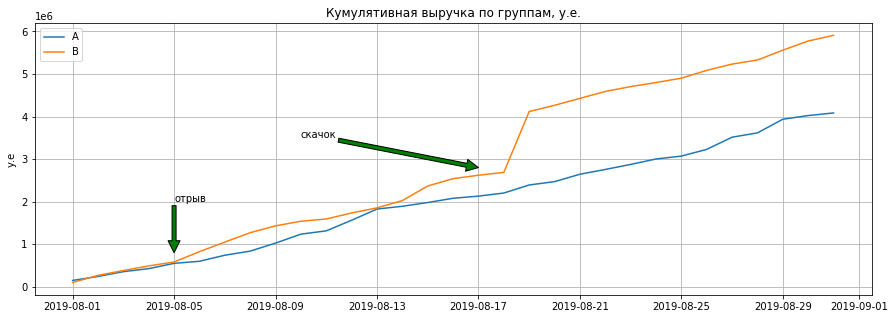

In [18]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize = (15,5))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.annotate('скачок', xy=(dt.date(2019, 8, 17), 2800000), xytext=(dt.date(2019, 8, 10), 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=(dt.date(2019, 8, 5), 800000), xytext=(dt.date(2019, 8, 5), 2000000),
            arrowprops=dict(facecolor='g')) 
plt.grid()
plt.legend()
plt.title('Кумулятивная выручка по группам, у.е.')
plt.ylabel('у.е')
plt.show();

А/B тест проведен по данным за месяц (август 2019). В середние месяца группа B начала уверенно лидировать по кумулятивной выручке. В 20-х числах произошло событие, которе повлекло за собой резкий скачок в выручки группы В. Как мы выяснили ранее группы А и В не равны между собой по количеству заказов, поэтому целесообразнее сравнивать средний чек. 

#### Кумулятивный средний чек по группам

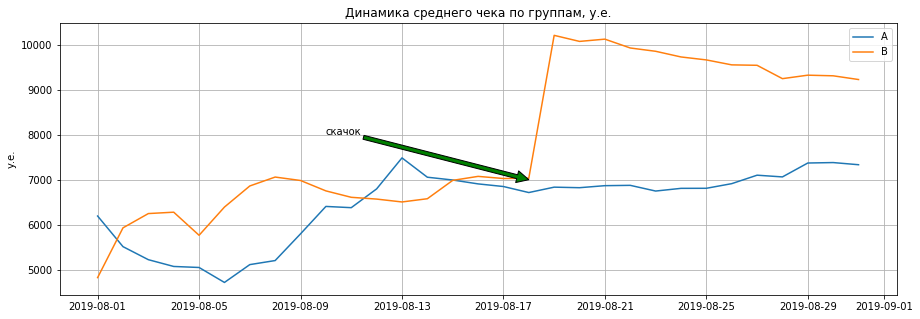

In [19]:
#Построим графики среднего чека по группам — 
#разделим кумулятивную выручку на кумулятивное число заказов
plt.figure(figsize = (15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()

plt.annotate('скачок', xy=(dt.date(2019, 8, 18), 7000), xytext=(dt.date(2019, 8, 10), 8000),
            arrowprops=dict(facecolor='g'))
plt.grid()
plt.title('Динамика среднего чека по группам, у.е.')
plt.ylabel('у.е.')
plt.show();

В 20-х числах мы также видим резкое увеличение кумулятивного среднего чека группы В. 

#### Относительное изменение кумулятивного среднего чека группы B к группе A

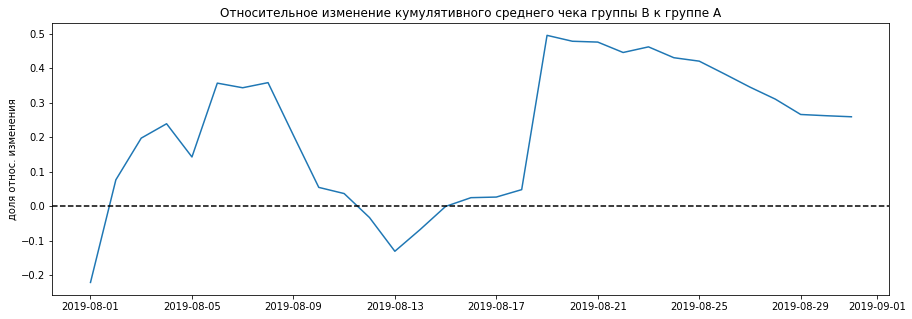

In [20]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize = (15,5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('доля относ. изменения')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A');

Анализ относителного изменения среднего чека B к А также показывает превосходство группы Б.

#### Кумулятивная конверсия по группам. 

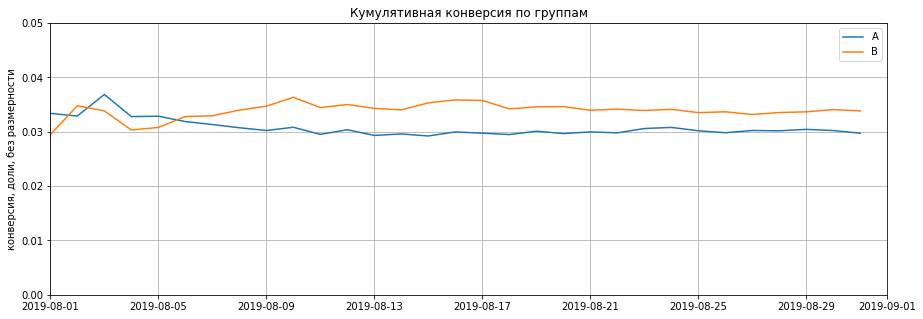

In [21]:

# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.figure(figsize = (15,5))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.grid()
plt.ylabel('конверсия, доли, без размерности')
plt.title('Кумулятивная конверсия по группам')
plt.legend()
# задаем масштаб осей
plt.axis([dt.date(2019, 8, 1), dt.date(2019, 9, 1), 0, 0.05]);


Кумулятивная конверсия довольно постоянна - на уровне 3 -3,5% для обоих групп. Конверсия группы B стабильно выше на 0.5%

#### Изменение относительной кумулятивной конверсии В к А

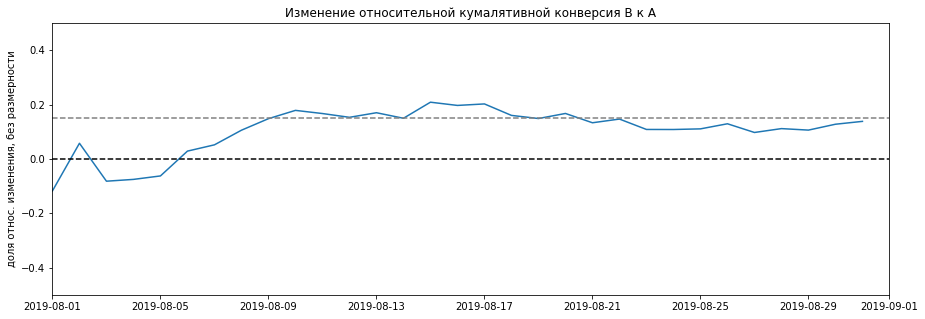

In [23]:

mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize = (15,5))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.axis([dt.date(2019, 8, 1), dt.date(2019, 9, 1), -0.5, 0.5])
plt.ylabel('доля относ. изменения, без размерности')
plt.title('Изменение относительной кумалятивной конверсия В к А');

Конверсия группы B стабильно лучше, чем у группы А

#### Количество заказов на одного пользователя 

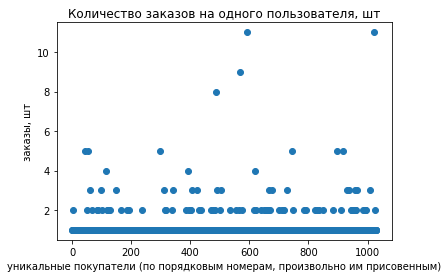

In [24]:
#считаем количество заказов на одного пользователя
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['visitorId', 'orders']

x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.ylabel('заказы, шт')
plt.xlabel('уникальные покупатели (по порядковым номерам, произвольно им присовенным)')
plt.title('Количество заказов на одного пользователя, шт'); 

Большинство покупателей не делали более двух-трех заказов за этот месяц.

#### Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [25]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


Не более 5% пользователей оформляли больше 2 заказов. И 1% пользователей заказывали более 4. 
Выберем границу 3 заказа.

#### Стоимость заказа  

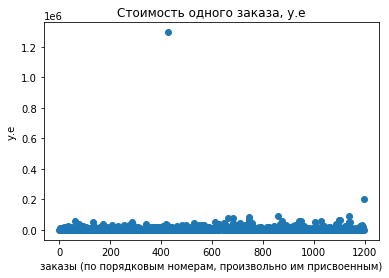

In [26]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.ylabel('у.е')
plt.xlabel('заказы (по порядковым номерам, произвольно им присвоенным)')
plt.title('Стоимость одного заказа, у.е');

#### Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [27]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


Выберем границу 28 000

#### Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. 

* Нулевая гипотеза: нет различий в конверсии между группами А и В. 
* Обратная гипотеза: различия в конверсии между двумя группами есть.

Альфа - 5%

При p-value меньше aльфа нулевая гипотеза отвергается.

In [28]:
#создаем датасеты, содержащие количество посетителей в каждый день отдельно для двух групп.
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

#создаем датасеты, содержащие количество заказов уникальных посетителей в каждый день 
#отдельно для двух групп (здесь посетители, оформившие хотя бы один заказ в этот день).
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

#создаем список покупателей с количеством заказов
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

#создаем список, содержащий:
sampleA = pd.concat(
    [
        #1) количество заказов на одного пользователя
        ordersByUsersA['orders'],
        #2) нули - для посетителей не сделавших ни одного заказа
        pd.Series(
            0,
            index=np.arange(
                #считаем количество посетителей, не сделавших заказ
                #(количество посетителей - количество покупателей:количество строк в списке покупателей) )
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#применяем тест Мана-Уитни к нашим спискам. 
#Среднее чисел в этих списках будет средней конверсией из визитов в заказы.

print('p-value:', "{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('относительная разница конверсии В к А:', "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


p-value: 0.017
относительная разница конверсии В к А: 0.138


По сырым данным p-value получилось менее 1%, что ниже уровня значимости альфа в 5%, значит отвергаем нулевую гипотезу, что группы А и B равны между собой. Относительный выигрыш группы B равен 13.8% 

#### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

* Нулевая гипотеза: нет различий в среднем чеке между группами А и В. 
* Обратная гипотеза: различия в среднем чеке между двумя группами есть.

Альфа - 5%

При p-value меньше aльфа нулевая гипотеза отвергается.

In [29]:
#применяем тест Мана-Уитни к series из стоимостей заказов, разделенных по группам А и В.
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
#считаем относительную разницу в среднем чеке между группами.
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

0.729
0.259


По сырым данным p-value получилось около 36%, что выше уровня значимости альфа в 5%, значит нет оснований отвергать нулевую гипотезу о равенстве групп. Однако относительный выигрыш группы B равен 26%, очень велик, хоть и статистически не значим.

#### Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным.

Мы проверим здесь одностороннюю гипотезу теста Мана Уитни, что конверсия группы B больше группы чем у А. 
* Нулевая гипотеза: нельзя судит о  различиях в конверсии между группами А и В. 
* Обратная гипотеза: Конверсия группы B больше чем А.

Альфа - 2.5%

При p-value меньше aльфа нулевая гипотеза отвергается, принимается обратная гипотеза. 

In [30]:
#cоздаем список с id покупателей, которые являются выбросами
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 3]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 3]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 28000]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
#print(abnormalUsers.head(5))
print('количество выбросов:', abnormalUsers.shape) 

#исключаем заказы покупателей, которые являются выбросами
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsADaily['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitorsBDaily['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)
print('Очищенная конверсия, aльфа = 2,5%(односторонний тест Мана-Уитни)')
print('p-value:', '{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, True, 'less')[1]))
print('конверсия B:', '{0:.3f}'.format(sampleBFiltered.mean()))
print('конверсия А:', '{0:.3f}'.format(sampleAFiltered.mean()))

количество выбросов: (63,)
Очищенная конверсия, aльфа = 2,5%(односторонний тест Мана-Уитни)
p-value: 0.009
конверсия B: 0.030
конверсия А: 0.027


То, что мы очистили данные от выбросов не повлияли на результаты теста Мана Уитни, он по прежнему говорит, что разница между конверсиями статистически значима, хоть и не выглядет большой. На очищенных данных мы провели односторонний тест. Он подтвердил, что конверсия группы В больше группы А.

#### Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [31]:
print('Средний чек, альфа 5% тест Мана-Уитни')
print('p-value '
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('относительная разница B к А '
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

Средний чек, альфа 5% тест Мана-Уитни
p-value 0.977
относительная разница B к А -0.017


Тест Мана Уитни, приминенный к очищенным данным также говорит о том, что гипотеза о равенстве групп не опровергается. Но разница получается намного меньше чем по сырым данным и с другим знаком. Ниже график среднего чека по очищенным данным для иллюстрации.

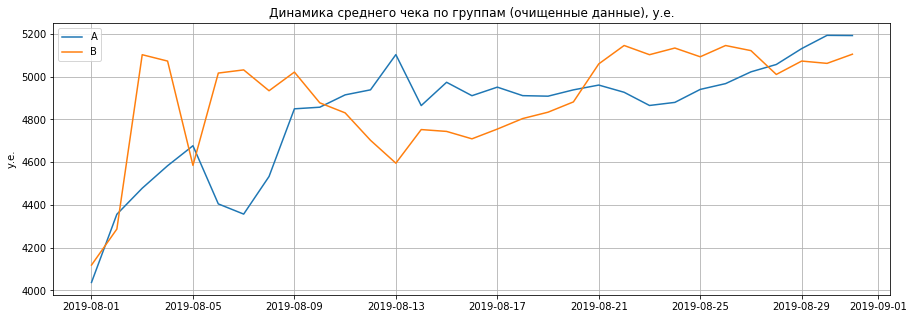

In [32]:
orders_filt = orders[np.logical_not(orders['visitorId'].isin(abnormalUsers))]

# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders_filt[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders_filt[np.logical_and(orders_filt['date'] <= x['date'], orders_filt['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize = (15,5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.grid()
plt.title('Динамика среднего чека по группам (очищенные данные), у.е.')
plt.ylabel('у.e.')
plt.show();

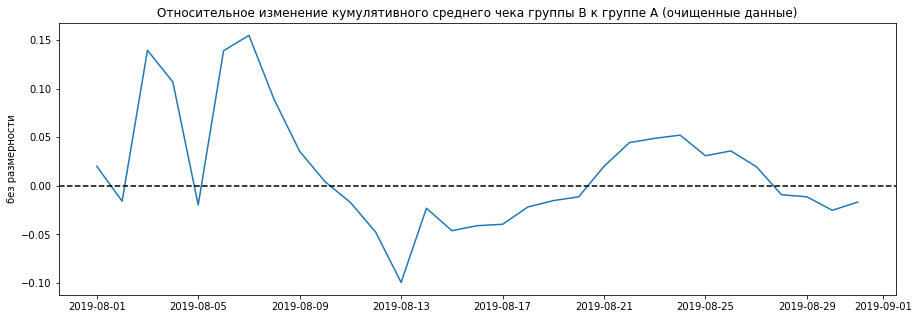

In [33]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize = (15,5))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A (очищенные данные)')
plt.ylabel('без размерности');

#### Примите решение по результатам теста. 

**Варианты решений:** 

* 1. Остановить тест, зафиксировать победу одной из групп. 

* 2. Остановить тест, зафиксировать отсутствие различий между группами. 

* 3. Продолжить тест.

**Принято решение остановить тест.**  
* По конверсиям группы различаются. Группа B побеждает с небольшим отрывом. 
* По размеру среднего чека не удалось выявить статистически значимых различий между группами. Тот факт что график кумулятивного среднего чека группы В с середины месяца значительно превышает чек группы А, объясняется выбросами. 

## Вывод 

Самыми выигрышными для проверки, согласно подходу RICE оказались гипотезы "Добавить форму для для e-mail подписки" и "Добавить блоки рекномендаций товаров на сайт".

В результате предобработки данных были выявлены замечания, но было решено проводить АB тест ввиду невозможности их поменять. Мы предполагаем, что эти проблемы с данными не критичны, тк. не превышают 10% всех данных.

Результаты АB теста:

* По конверсиям группы различаются. Группа B побеждает с небольшим отрывом. 
* По размеру среднего чека не удалось выявить статистически значимых различий между группами. 
